Training LSTM model for 7-day prediction...
Epoch 1/50
40/40 [==============================] - 2s 15ms/step - loss: 0.0286 - val_loss: 0.0085
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 3/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0088
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0088
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0054
Epoch 6/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0054
Epoch 7/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 8/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 9/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 10/50
40/40 [==============================] - 0s 4ms/step - loss: 

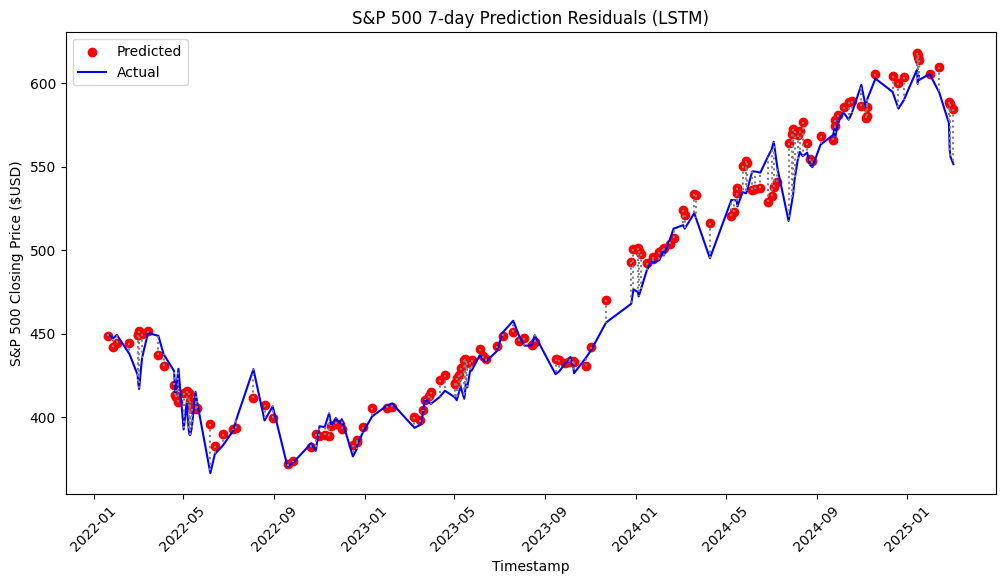

Training LSTM model for 30-day prediction...
Epoch 1/50
39/39 [==============================] - 3s 16ms/step - loss: 0.0558 - val_loss: 0.0101
Epoch 2/50
39/39 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0090
Epoch 3/50
39/39 [==============================] - 0s 5ms/step - loss: 0.0141 - val_loss: 0.0079
Epoch 4/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.0080
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0056
Epoch 6/50
39/39 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0059
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0050
Epoch 8/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 9/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0078
Epoch 10/50
39/39 [==============================] - 0s 4ms/step - loss:

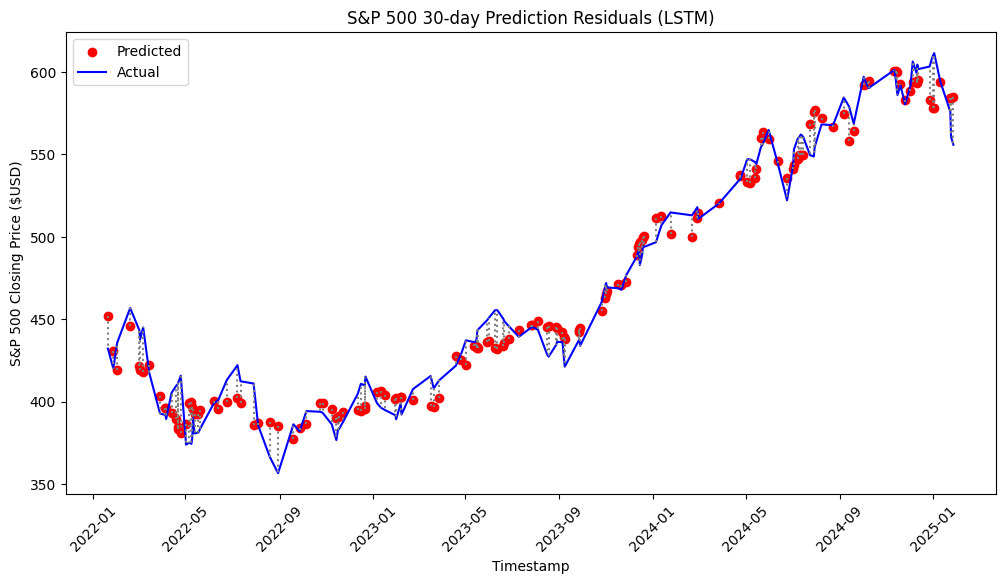

Training LSTM model for 180-day prediction...
Epoch 1/50
31/31 [==============================] - 3s 18ms/step - loss: 0.0378 - val_loss: 0.0084
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0049
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0047
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 7/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 8/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 9/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 10/50
31/31 [==============================] - 0s 4ms/step - loss

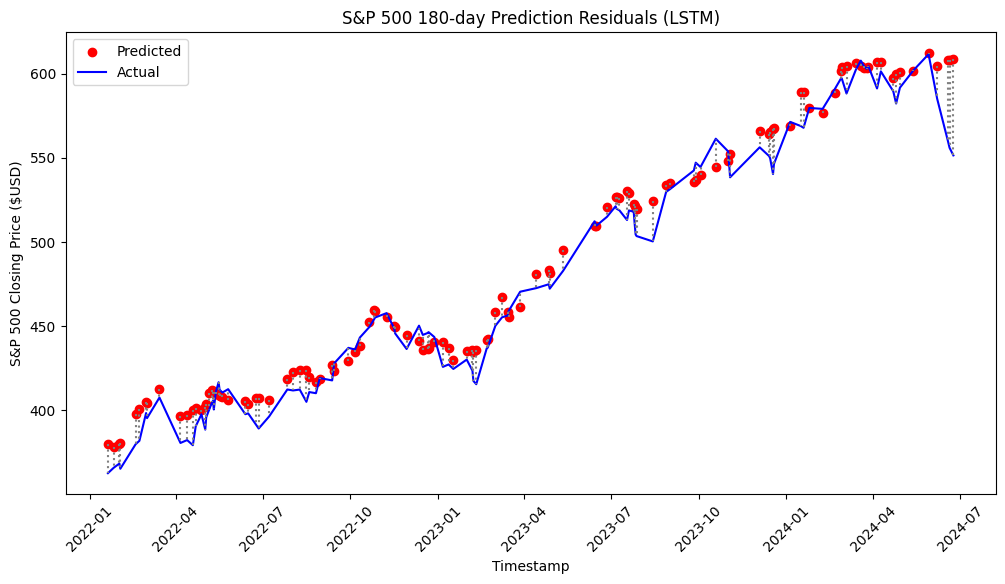

Final results: {7: {'R²': 0.9625232989016382, 'MAE': 10.387711212741344, 'MSE': 192.73634265584664, 'RMSE': 13.882951510966485}, 30: {'R²': 0.9677329114739478, 'MAE': 10.840863643471716, 'MSE': 176.04225350869726, 'RMSE': 13.268091554880726}, 180: {'R²': 0.9675268914285357, 'MAE': 10.048793320074314, 'MSE': 180.76045162771612, 'RMSE': 13.444718354347037}}


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define file path
data_path = "data"
file_names = {
    "bitcoin": "bitcoin.csv",
    "gold": "gold.csv",
    "google_trends": "google_trends.csv",
    "sp500": "sp500.csv",
    "treasury_3m": "treasury_3m.csv",
    "treasury_10y": "treasury_10y.csv",
}

# Load datasets
data = {}
for key, file in file_names.items():
    file_path = os.path.join(data_path, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["timestamp"])
        df.replace({'.': np.nan}, inplace=True)  # Replace non-numeric values with NaN
        for col in df.columns:
            if col != "timestamp":
                df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
        data[key] = df
    else:
        print(f"File not found: {file_path}")

# Merge datasets on timestamp
sp500 = data["sp500"]
sp500 = sp500.rename(columns={"Close": "sp500_close"})
all_data = sp500[["timestamp", "sp500_close"]]

for key, df in data.items():
    if key != "sp500" and df is not None:
        all_data = all_data.merge(df, on="timestamp", how="left")

# Convert timestamp back to datetime for sorting
all_data["timestamp"] = pd.to_datetime(all_data["timestamp"])
all_data.sort_values("timestamp", inplace=True)

# Fill missing values
all_data.fillna(method='ffill', inplace=True)

# **Scale features but keep a separate scaler for the target**
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Apply MinMax scaling to features only
feature_columns = [col for col in all_data.columns if col not in ["timestamp", "sp500_close"]]
all_data[feature_columns] = feature_scaler.fit_transform(all_data[feature_columns])

# Fit the scaler on S&P 500 closing price (target variable)
all_data["sp500_close_scaled"] = target_scaler.fit_transform(all_data[["sp500_close"]])

# Define prediction intervals
prediction_intervals = [7, 30, 180]
results = {}

for interval in prediction_intervals:
    print(f"Training LSTM model for {interval}-day prediction...")

    # Create target variable
    all_data[f"sp500_target_{interval}"] = all_data["sp500_close_scaled"].shift(-interval)

    # Drop rows with NaN values
    model_data = all_data.dropna(subset=[f"sp500_target_{interval}"])
    
    # Define features and target
    X = model_data[feature_columns].values
    y = model_data[f"sp500_target_{interval}"].values
    timestamps = model_data["timestamp"].values  # Store timestamps for plotting

    # Reshape input for LSTM (samples, time_steps, features)
    time_steps = 10  # Using past 10 days to predict the future
    X_lstm = []
    y_lstm = []
    timestamps_lstm = []

    for i in range(len(X) - time_steps):
        X_lstm.append(X[i : i + time_steps])
        y_lstm.append(y[i + time_steps])
        timestamps_lstm.append(timestamps[i + time_steps])  # Match timestamps with predictions

    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    timestamps_lstm = np.array(timestamps_lstm)

    # Train-test split
    X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
        X_lstm, y_lstm, timestamps_lstm, test_size=0.2, random_state=42)

    # Define LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer="adam", loss="mse")

    # Train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    # Predict values
    y_pred = model.predict(X_test)

    # **FIX: Inverse transform only the target variable**
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Evaluation metrics
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)

    results[interval] = {"R²": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}

    print(f"Results for {interval}-day prediction:")
    print(f"R² score: {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Sort values by timestamp for plotting
    sorted_indices = np.argsort(timestamps_test)
    timestamps_sorted = timestamps_test[sorted_indices]
    y_test_sorted = y_test_original[sorted_indices]
    y_pred_sorted = y_pred_original[sorted_indices]

    # **FIX: Use actual prices instead of scaled values**
    plt.figure(figsize=(12, 6))
    plt.scatter(timestamps_sorted, y_pred_sorted, label="Predicted", color='red', marker='o')  # Predictions as dots
    plt.plot(timestamps_sorted, y_test_sorted, label="Actual", color='blue')  # Actual values as a line

    # Draw residual lines
    for i in range(len(timestamps_sorted)):
        plt.plot([timestamps_sorted[i], timestamps_sorted[i]], 
                 [y_pred_sorted[i], y_test_sorted[i]], 
                 color='gray', linestyle='dotted')

    plt.title(f"S&P 500 {interval}-day Prediction Residuals (LSTM)")
    plt.xlabel("Timestamp")
    plt.ylabel("S&P 500 Closing Price ($USD)")  # **FIXED Y-axis label**
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Output results
print("Final results:", results)
